In [ ]:
!pip3 install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [6]:
% cd /home/pekudrjavtseva/transformers/notebooks

/home/pekudrjavtseva/transformers/notebooks


In [7]:
from functions import *
from pathlib import Path
from sklearn.model_selection import train_test_split

%matplotlib inline

In [8]:
PRETRAINED_PATH = '/home/pekudrjavtseva/transformers/checkpoints/conformer/Conformer_base_patch16.pth'

LABELS_PATH = '/home/pekudrjavtseva/transformers/data/dogs/labels.csv'

MODEL_SAVE_PATH = '/home/pekudrjavtseva/transformers/models/conformer.pth'

MODEL_SAVE_PATH_SHORT = '/home/pekudrjavtseva/transformers/models/conformer_short.pth'

TRAIN_DIR = Path('/home/pekudrjavtseva/transformers/data/dogs/train')

TEST_DIR = Path('/home/pekudrjavtseva/transformers/data/dogs/test')

TRAIN_DIR_SHORT = Path('/home/pekudrjavtseva/transformers/data/dogs_short')

RESULT_PATH_FULL = '/home/pekudrjavtseva/transformers/predictions/conformer_full.csv'

RESULT_PATH_SHORT = '/home/pekudrjavtseva/transformers/predictions/conformer_short.csv'

DEVICE = torch.device("cuda")

In [9]:
%cd ../image-classification

/home/pekudrjavtseva/transformers/image-classification


In [10]:
from models import get_model

model = get_model('Conformer', 'B', pretrained = PRETRAINED_PATH)

In [24]:
d = create_labels(LABELS_PATH)

In [25]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [d[path.name] for path in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

train_dataset = DogsDataset(train_files, mode='train', label_path = LABELS_PATH)

val_dataset = DogsDataset(val_files, mode='val', label_path = LABELS_PATH)

test_dataset = DogsDataset(test_files, mode='test', label_path = LABELS_PATH)

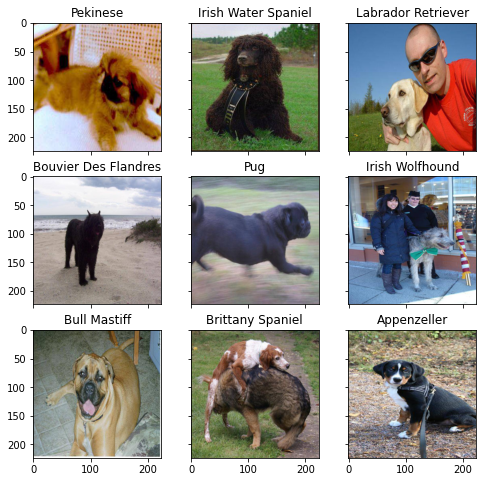

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
 random_characters = int(np.random.uniform(0,1000))
 im_val, label = train_dataset[random_characters]
 img_label = " ".join(map(lambda x: x.capitalize(),\
 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

 imshow(im_val.data.cpu(), \
 title=img_label,plt_ax=fig_x)

In [10]:
name = MODEL_SAVE_PATH

torch.cuda.set_device(7)
torch.cuda.empty_cache()

opt = torch.optim.AdamW(model.parameters(), lr=3e-5, amsgrad=True)
history = train(train_dataset, val_dataset, model= model.cuda(), opt = opt, epochs=10, batch_size=16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.899063089887249


epoch:  10%|█         | 1/10 [03:25<30:50, 205.64s/it]

Saved model with val acc 0.8869327073552425

Epoch 001 train_loss: 3.8991   val_loss 0.7723 train_acc 0.2579 val_acc 0.8869
loss 0.40738046264915906


epoch:  20%|██        | 2/10 [06:42<27:04, 203.12s/it]

Saved model with val acc 0.8971048513302035

Epoch 002 train_loss: 0.4074   val_loss 0.4197 train_acc 0.9079 val_acc 0.8971
loss 0.20624864657530734


epoch:  30%|███       | 3/10 [09:59<23:28, 201.21s/it]

Saved model with val acc 0.9131455399061033

Epoch 003 train_loss: 0.2062   val_loss 0.3606 train_acc 0.9463 val_acc 0.9131
loss 0.10744604536621573


epoch:  40%|████      | 4/10 [13:16<20:00, 200.03s/it]

Saved model with val acc 0.9158841940532082

Epoch 004 train_loss: 0.1074   val_loss 0.3375 train_acc 0.9709 val_acc 0.9159
loss 0.07729652108993414


epoch:  50%|█████     | 5/10 [16:33<16:35, 199.02s/it]

Saved model with val acc 0.917057902973396

Epoch 005 train_loss: 0.0773   val_loss 0.3610 train_acc 0.9786 val_acc 0.9171
loss 0.06323896127174923


epoch:  60%|██████    | 6/10 [19:49<13:12, 198.04s/it]


Epoch 006 train_loss: 0.0632   val_loss 0.3241 train_acc 0.9836 val_acc 0.9124
loss 0.027596890627502025


epoch:  70%|███████   | 7/10 [23:05<09:52, 197.62s/it]

Saved model with val acc 0.9190140845070423

Epoch 007 train_loss: 0.0276   val_loss 0.3316 train_acc 0.9927 val_acc 0.9190
loss 0.011922296868579376


epoch:  80%|████████  | 8/10 [26:22<06:34, 197.34s/it]

Saved model with val acc 0.9221439749608764

Epoch 008 train_loss: 0.0119   val_loss 0.3255 train_acc 0.9983 val_acc 0.9221
loss 0.008559705563020296


epoch:  90%|█████████ | 9/10 [29:38<03:16, 196.88s/it]


Epoch 009 train_loss: 0.0086   val_loss 0.3309 train_acc 0.9987 val_acc 0.9221
loss 0.00612530825762168


epoch: 100%|██████████| 10/10 [32:54<00:00, 197.41s/it]


Epoch 010 train_loss: 0.0061   val_loss 0.3377 train_acc 0.9988 val_acc 0.9190


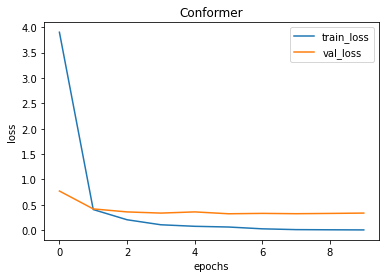

In [11]:
plot(history, "Conformer")

In [26]:
def make_prediction(name, model, test_files):
    checkpoint = torch.load(name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    test_dataset = DogsDataset(test_files, mode='test', label_path = LABELS_PATH)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=2)

    probs = predict(model, test_loader)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    result = pd.DataFrame(columns = label_encoder.inverse_transform(np.arange(0, 120)))

    result['id'] = [path.name.split('.')[0] for path in test_files]

    for i in range(len(test_files)):
        result.iloc[i, :-1] = probs[i][:120]

    return result

In [13]:
res = make_prediction(name, model, test_files)
res.to_csv(RESULT_PATH_FULL, index = False)

Kaggle score 0.31189

In [27]:
train_val_files_short = sorted(list(TRAIN_DIR_SHORT.rglob('*.jpg')))

train_val_labels_short = [d[path.name] for path in train_val_files_short]

train_files_short, val_files_short = train_test_split(train_val_files_short, test_size=0.25, \
 stratify=train_val_labels_short)

train_dataset_short = DogsDataset(train_files_short, mode='train',  label_path = LABELS_PATH)

val_dataset_short = DogsDataset(val_files_short, mode='val',  label_path = LABELS_PATH)

In [28]:
model = get_model('Conformer', 'B', pretrained = PRETRAINED_PATH)
name = MODEL_SAVE_PATH_SHORT

torch.cuda.empty_cache()

opt = torch.optim.AdamW(model.parameters(), lr=3e-5, amsgrad=True)
history = train(train_dataset_short, val_dataset_short, model= model.cuda(), opt = opt, epochs=10, batch_size=16, name = name)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 5.3382813485331555


epoch:  10%|█         | 1/10 [01:16<11:31, 76.79s/it]

Saved model with val acc 0.22797927461139894

Epoch 001 train_loss: 5.3383   val_loss 3.9233 train_acc 0.0263 val_acc 0.2280
loss 1.7008195679588436


epoch:  20%|██        | 2/10 [02:31<10:09, 76.20s/it]

Saved model with val acc 0.8974093264248705

Epoch 002 train_loss: 1.7008   val_loss 0.5810 train_acc 0.7382 val_acc 0.8974
loss 0.3305254842812919


epoch:  30%|███       | 3/10 [03:46<08:51, 75.92s/it]

Saved model with val acc 0.9015544041450777

Epoch 003 train_loss: 0.3305   val_loss 0.4542 train_acc 0.9412 val_acc 0.9016
loss 0.16219964710013995


epoch:  40%|████      | 4/10 [05:02<07:34, 75.76s/it]

Saved model with val acc 0.9202072538860103

Epoch 004 train_loss: 0.1622   val_loss 0.3397 train_acc 0.9668 val_acc 0.9202
loss 0.07082726520178312


epoch:  50%|█████     | 5/10 [06:18<06:19, 75.87s/it]

Saved model with val acc 0.9253886010362694

Epoch 005 train_loss: 0.0708   val_loss 0.3142 train_acc 0.9896 val_acc 0.9254
loss 0.036297285439830435


epoch:  60%|██████    | 6/10 [07:33<05:02, 75.57s/it]


Epoch 006 train_loss: 0.0363   val_loss 0.2959 train_acc 0.9962 val_acc 0.9212
loss 0.020853997210754316


epoch:  70%|███████   | 7/10 [08:47<03:45, 75.28s/it]


Epoch 007 train_loss: 0.0209   val_loss 0.3103 train_acc 0.9976 val_acc 0.9244
loss 0.013187051835092478


epoch:  80%|████████  | 8/10 [10:03<02:30, 75.42s/it]

Saved model with val acc 0.9264248704663212

Epoch 008 train_loss: 0.0132   val_loss 0.3035 train_acc 0.9997 val_acc 0.9264
loss 0.009082779102800299


epoch:  90%|█████████ | 9/10 [11:18<01:15, 75.35s/it]

Saved model with val acc 0.927461139896373

Epoch 009 train_loss: 0.0091   val_loss 0.3204 train_acc 0.9997 val_acc 0.9275
loss 0.006895130641892408


epoch: 100%|██████████| 10/10 [12:34<00:00, 75.47s/it]

Saved model with val acc 0.9316062176165802

Epoch 010 train_loss: 0.0069   val_loss 0.2955 train_acc 1.0000 val_acc 0.9316


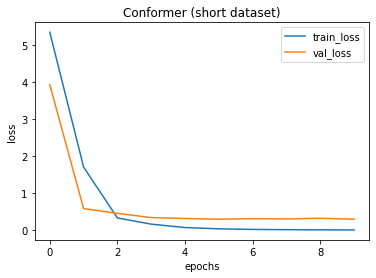

In [29]:
plot(history, "Conformer (short dataset)")

In [30]:
res = make_prediction(name, model, test_files)
res.to_csv(RESULT_PATH_SHORT, index = False)

Kaggle score 0.33163